In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker
import folium

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

## Validating the GTFS stops and CIS data in directions

### Comparing the the frequency of stop sequences of GTFS data in hours 6-25 and CIS data in hours 0-23

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [42]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [43]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [44]:
# Chelseas query with stops with no pickup or dropoff are filtered out 
sql_GTFS_0b = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 AND pickup_type <> 1 AND drop_off_type <> 1
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2b = pandasql.read_sql(sql_GTFS_0b, con)

df2b = df2b.pivot("hours", "stop_sequence", "schedule")


In [45]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691042
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [46]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691040
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

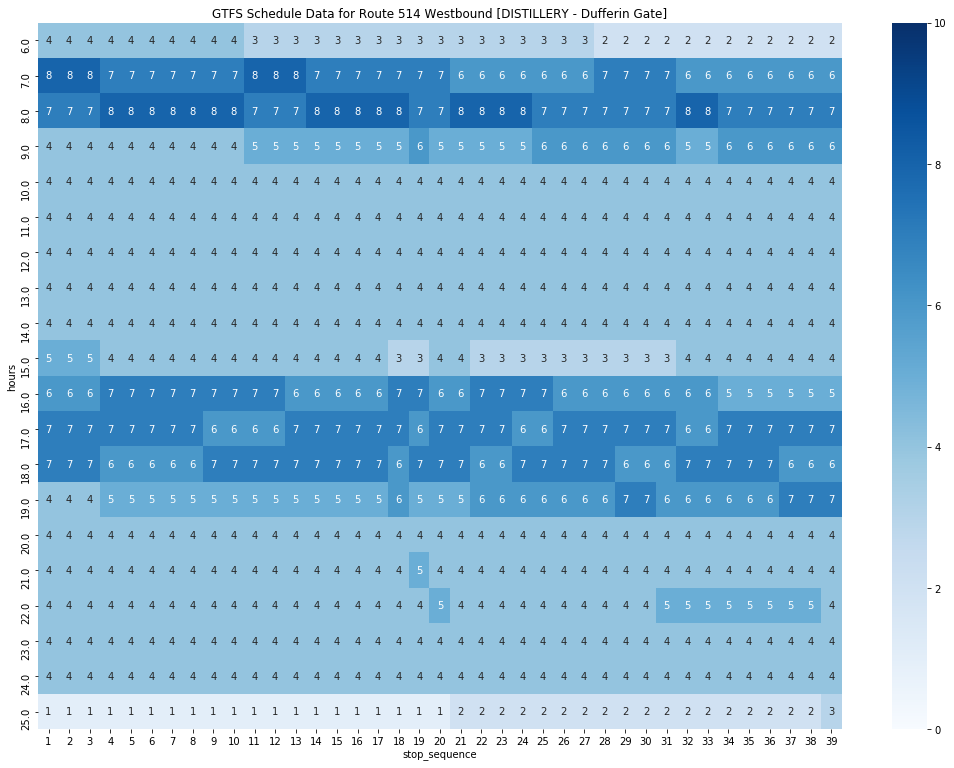

In [47]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

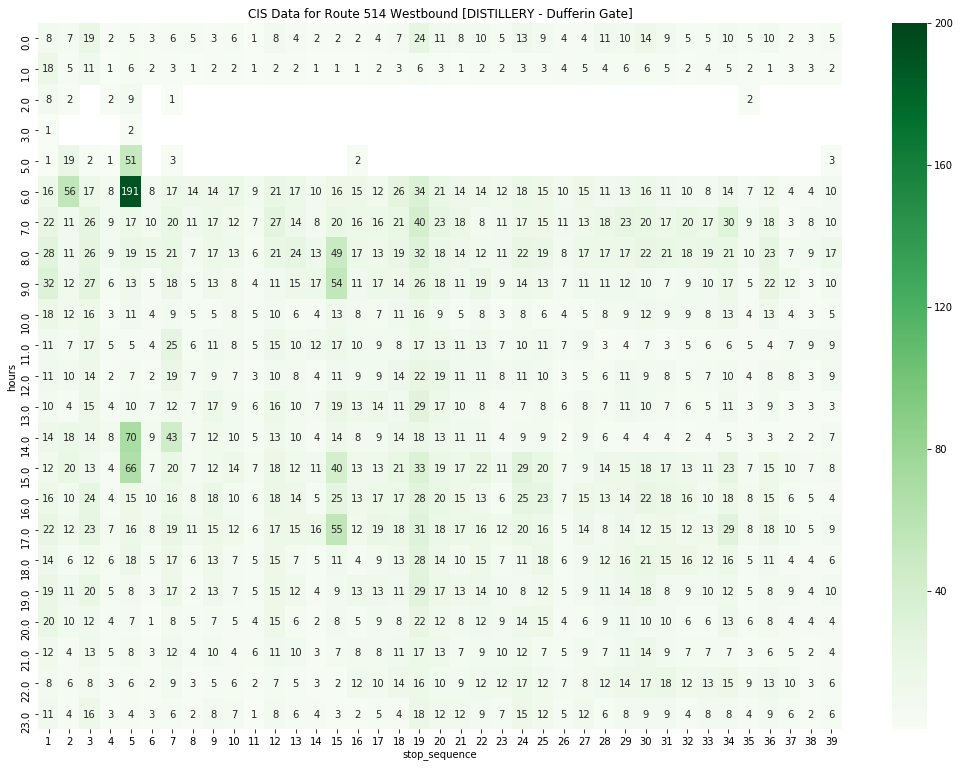

In [48]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

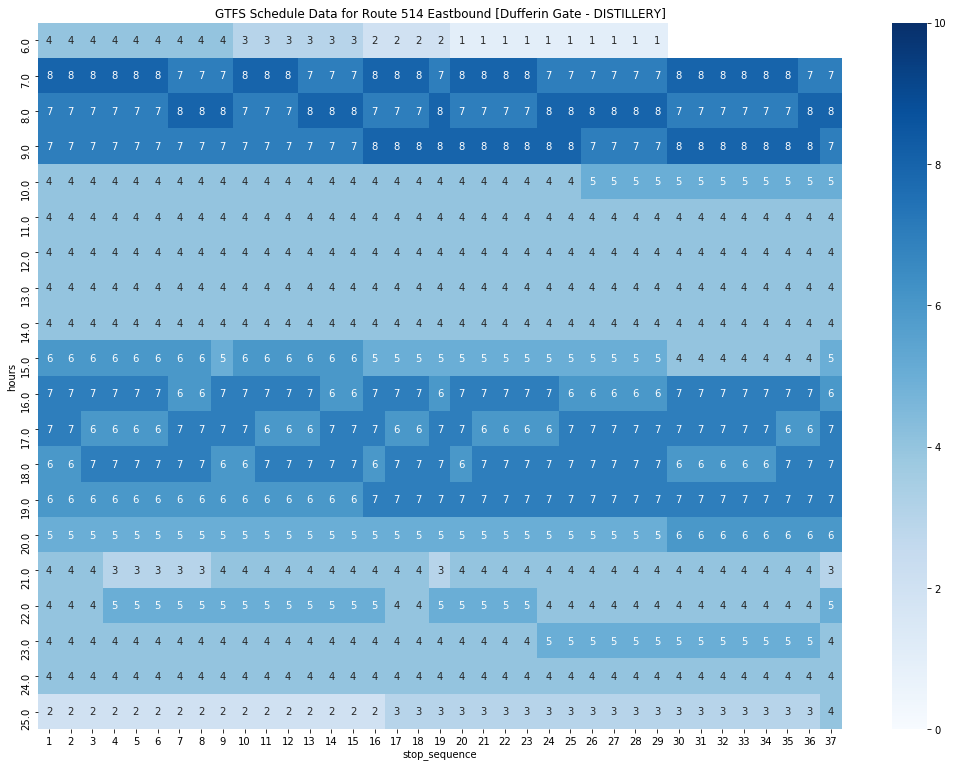

In [49]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

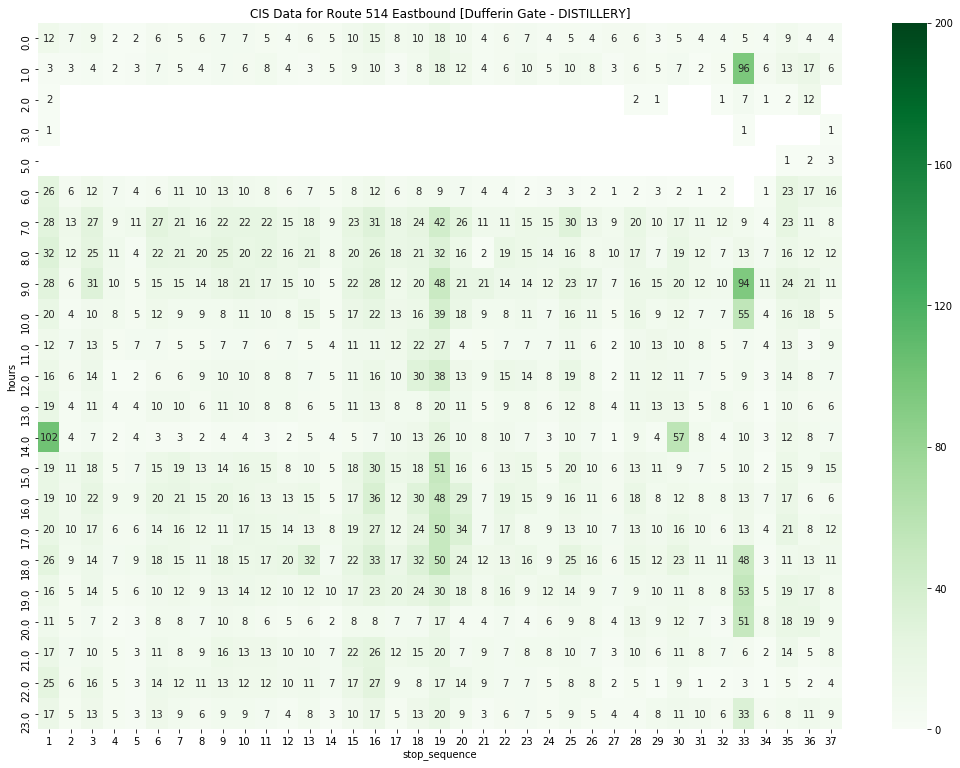

In [50]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df4, vmin=0, vmax=200,cmap = 'Greens', annot=True, fmt='g')

### Validating and Comparing the numbers of GTFS data and CIS data in different stop sequences in a day.

#### The heat maps represent the difference between the count of GTFS schedule service and the count of CIS data with the same stop sequence in hours in the direction of 0 and 1.

In [51]:
# FOR route 514
sql_heatmaps = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_514
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

heatmap_df = pandasql.read_sql(sql_heatmaps, con)

DatabaseError: Execution failed on sql '
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_514
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
': relation "match_stop_514" does not exist
LINE 20: FROM match_stop_514
              ^


In [ ]:
heatmap_df_d1 = heatmap_df[heatmap_df['direction_ids']==1]

heatmap_df_d1 = heatmap_df_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 DISTILLERY to Dufferin Gate: GTFS - Processed CIS')
sns.heatmap(heatmap_df_d1, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

In [ ]:
heatmap_df_d0 = heatmap_df[heatmap_df['direction_ids']==0]

heatmap_df_d0 = heatmap_df_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 Dufferin Gate to DISTILLERY: GTFS - Processed CIS')
sns.heatmap(heatmap_df_d0, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

There are some extreme high different values (dark blue cells) at 9 A.M. with stop sequence of 3 and at 6 A.M with stop sequence of 5 when direction_id = 1, and at 6 A.M. with stop sequence of 35 and 36 when direction_id = 0.

In [ ]:
# Find the stop IDs and names of the dark blue cells.

sql_stop_sequence = '''
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, stop_name, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042) AND 
((stop_sequence IN (3, 5) AND direction_id = 1) 
OR (stop_sequence IN (35, 36) AND direction_id = 0))
'''

print_table(sql_stop_sequence, con)

Using the following query, points from the matched stops table were mapped for 6AM where they matched with King St @ Sackville
```sql
SELECT *
 FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1 AND EXTRACT(hour from date_time)  =  6 AND stop_id = 7621
```
We can see that the CIS data showed these were on route 514, despite being on King/Queen past where the 514 turns onto Cherry St. 
![](img/king_sackville_514.PNG)

Now examining some of the stops which are very red above, implying that few CIS records were matched to them. The following query outputs data for stops in the Westbound direction between sequence 8 and 13, stop sequence 11 has few matched CIS records. The larger circles are the stop locations, and the smaller circles are CIS records. The two sets have been colour-coded to match based on stop_sequence number

![](img/king_sherbourne_514.PNG)

We can see that there are multiple scheduled GTFS stops at the same intersection, so few records are ultimately getting matched to 11, because it is in the middle of the intersection. Further inspection of the GTFS data shows that `pickup_type` and `drop_off_type` at this location are 1 which mean:
>**1** - No pickup available  
>**1** - No drop off available

These stops should be filtered out

The stops outputted are closed to or equal to the terminals. The reason of the negative value at these stops at 6 A.M. or 9 A.M. could be that inaccurate GPS locates the streetcars at those stops when streetcars are waiting at the terminals.

In [52]:
sql_stops = '''
SELECT DISTINCT ON(direction_id, stop_sequence , stop_id) stop_id, stop_sequence, stop_name, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
'''

print_table(sql_stops, con)

stop_id,stop_sequence,stop_name,direction_id,shape_id
13268,1,EXHIBITION WEST LOOP,0,691040
6113,2,DUFFERIN GATE LOOP,0,691040
8860,3,DUFFERIN ST AT LIBERTY ST,0,691040
15344,4,DUFFERIN ST AT KING ST WEST,0,691040
13150,5,DUFFERIN AT KING,0,691040
7384,6,KING ST WEST AT FRASER AVE,0,691040
5467,7,KING ST WEST AT ATLANTIC AVE,0,691040
8998,8,KING ST WEST AT SUDBURY ST,0,691040
5422,9,KING ST WEST AT SHAW ST,0,691040
437,10,KING ST WEST AT STRACHAN AVE,0,691040


## Dwell Time Analysis


In [53]:
sql_timediff = '''
SELECT EXTRACT(EPOCH FROM departure_time - arrival_time)/60 AS time_diff
FROM dzou2.match_stop_514
'''
timediff = pandasql.read_sql(sql_timediff, con)

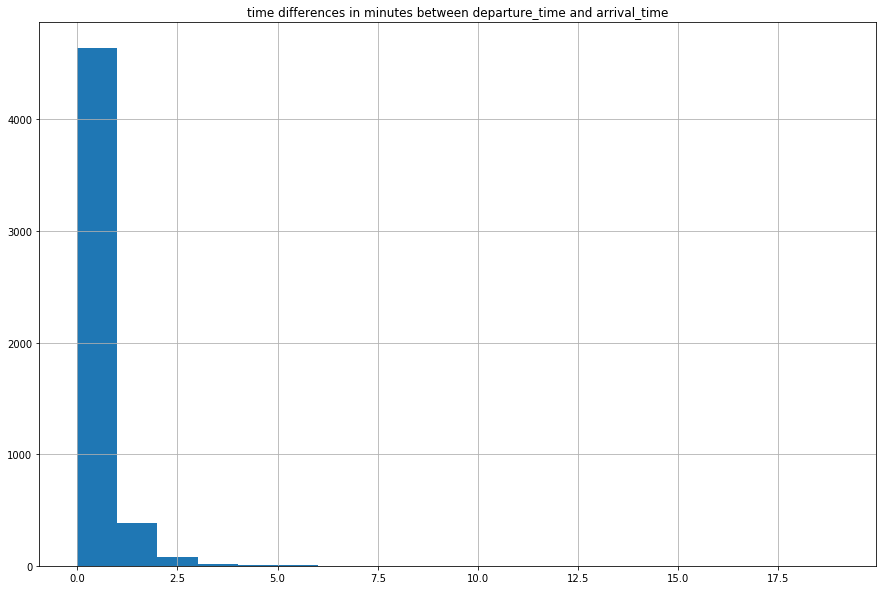

In [54]:
bin_val = np.arange(min(timediff['time_diff']), max(timediff['time_diff']), 1)

timediff.hist(bins=bin_val, figsize=(15,10))
plt.title('time differences in minutes between departure_time and arrival_time')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15) 

There are some values after 5 in the above histogram, but they are not clear since the range of y axis is large (0-4000+), so making another histogram only focuses on the values after 5.

NameError: name 'matplotlib' is not defined

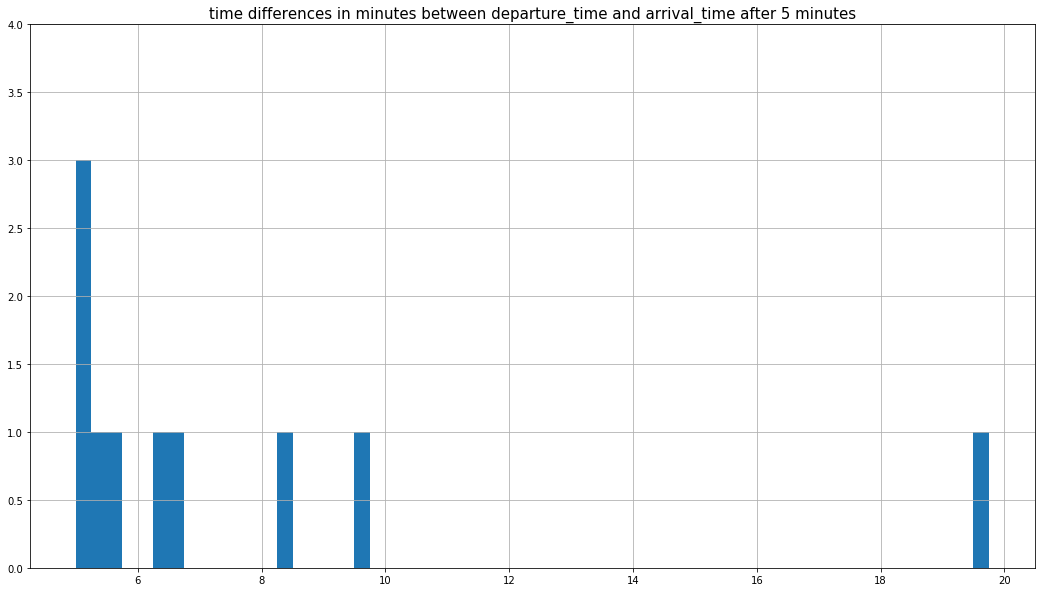

In [55]:
timediff.hist(bins = np.arange(5, 20, 0.25), figsize=(18,10))
plt.title('time differences in minutes between departure_time and arrival_time after 5 minutes')
ax = plt.gca()
ax.set_ylim([0, 4])
f = lambda x,pos: str(x).rstrip('0').rstrip('.')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(f))

plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)    

### The heat maps of Route 504

In [ ]:
sql_504_heatmaps = '''
WITH 
gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_504
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504' AND shape_id IN (690863, 690880)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

heatmap_514 = pandasql.read_sql(sql_504_heatmaps, con)

In [ ]:
heatmap_514_d1 = heatmap_514[heatmap_514['direction_ids']==1]

heatmap_514_d1 = heatmap_514_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Broadview Station to Dundas West Station: GTFS - Processed CIS')
sns.heatmap(heatmap_514_d1, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

In [ ]:
heatmap_514_d0 = heatmap_514[heatmap_514['direction_ids']==0]

heatmap_514_d0 = heatmap_514_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Dundas West Station to Broadview Station: GTFS - Processed CIS')
sns.heatmap(heatmap_514_d0, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

### Assign Trip IDs to CIS data 


In [21]:
# create original table in my db 

sql_delete = '''
DELETE FROM crosic.cis_504_10042017_tripids;
'''

sql_insert = '''
INSERT INTO crosic.cis_504_10042017_tripids(arrival_time, departure_time, vehicle, 
stop_id, direction_id, cis_group, orderid)

(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_504
ORDER BY vehicle, arrival_time);
'''

#with con:
 #   with con.cursor() as cur:
  #      cur.execute(sql_delete)
   #     cur.execute(sql_insert)


Now we have a table where we can start defining the trip IDs. 

Assign the trip IDs for the CIS data of **route 514 on 10/04/2017** which have more than 10 CIS position records in one trip, and for the CIS data of **route 504 on 10/04/2017** which have at least 10 CIS position records in one trip. There are some CIS data records change their directions abnormally, and some CIS data change their closest stops frequently in the terminal areas because of the unstability of GPS. The abnormal points create short trips as the table shown below, and filtering out the short trips can help to assign the trip IDs to the more reliable CIS data.

In [34]:
sql_find_tripIDs1 = '''
DO $$
DECLARE curr_id INTEGER;
BEGIN
curr_id := 0;

UPDATE crosic.cis_504_10042017_tripids
SET tripid = (CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN curr_id +1, curr_id = curr_id + 1
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN curr_id + 1, curr_id = curr_id + 1
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN curr_id
END);

END $$;

'''

sql_find_tripIDs2 = '''
CREATE TEMPORARY SEQUENCE seq;
SELECT setval('seq', 1);


UPDATE crosic.cis_504_10042017_tripids
SET tripid =(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('seq')
END);

'''

sql_find_tripIDs3 = '''
-- DROP TEMPORARY SEQUENCE tripid_seq;
-- CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_504_10042017_tripids
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_group) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id; 

-- DROP TEMPORARY SEQUENCE tripid_seq;
'''


sql_find_tripIDs4 = '''
DROP TABLE IF EXISTS crosic.cis_504_10042017_tripids2; 
-- CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
INTO crosic.cis_504_10042017_tripids2
FROM crosic.cis_504_10042017_tripids
ORDER BY vehicle, arrival_time


-- DROP TEMPORARY SEQUENCE tripid_seq;
'''


with con:
    with con.cursor() as cur:
        cur.execute(sql_find_tripIDs4)



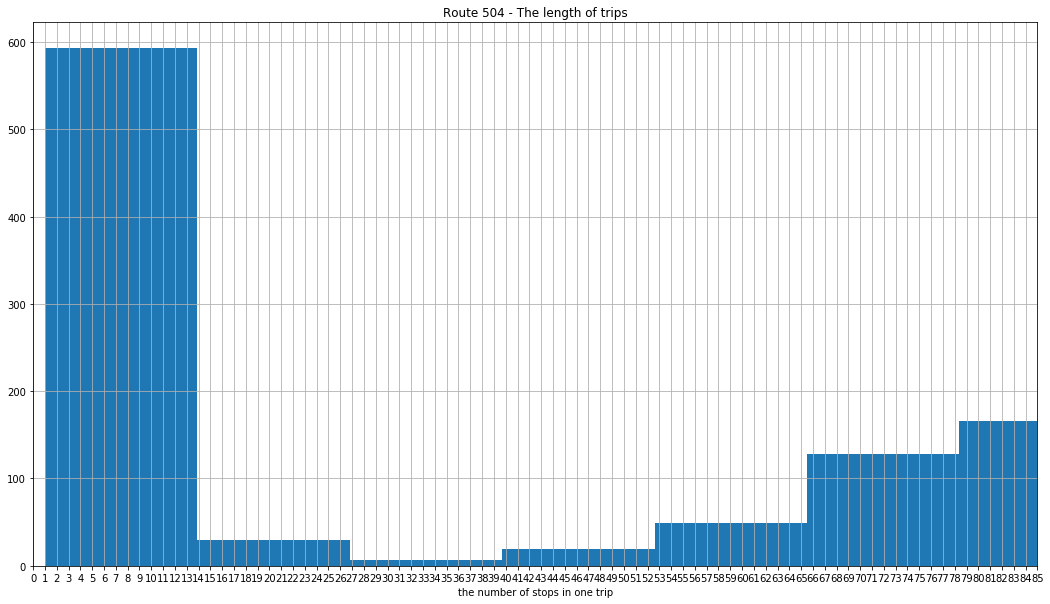

In [35]:
trips_504 = pandasql.read_sql(sql_find_tripIDs3, con)
trips_504.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 85])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

As the table shown, the longest trip has 80+ CIS data records, and the shorter trips have 20+ data records. However, there are multiple trips have 1-9 data records which may be the trips with errors, and there are few trips with has the number of data records between 9 and 20. The fracture seems like the indicator, and the trips with less than 10 data records are too short, so the trips with less than 10 data records will be filtered out.

Upon further investigation, there was a lot of direction changes around the same time near the two subway stations that the streetcar goes to. (Broadview with stopID 13050 and Dundas West with sopID 13209).

Now do the same thing for the 514

In [ ]:
sql_delete = '''
DELETE FROM crosic.cis_514_10042017_tripids;
'''

sql_insert = '''
SELECT * INTO crosic.cis_514_10042017_tripids
FROM
(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_514
ORDER BY vehicle, arrival_time) AS T;
'''
with con:
    with con.cursor() as cur:
        #cur.execute(sql_delete)
        cur.execute(sql_insert)

In [27]:
sql_find_tripIDs3 = '''
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT trip_id
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_514_10042017_tripids
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_group) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id;
'''


sql_find_tripIDs4 = '''
-- CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
INTO crosic.cis_514_10042017_tripids2
FROM crosic.cis_514_10042017_tripids
ORDER BY vehicle, arrival_time;
'''


with con:
    with con.cursor() as cur:
        cur.execute(sql_find_tripIDs4)

ProgrammingError: relation "cis_514_10042017_tripids2" already exists


In [32]:
sql_504_shapes = '''
SELECT shape_id, count(*) FROM dzou2.dd_504_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_504_shapes, con)

shape_id,count
690864,10
690866,11
690882,12
690881,14
690867,50
690873,53
690860,58
690859,59
690863,59
690880,65


The stops that have under 10 stops for route 504 should be examined.

The number of stops of the shortest shape for route 504 is 10, so each trip should have at least 10 data records.

(The reason why not using this method for route 514 is that the number of stops of shortest shape in route 514 is 30, which will filtered out too many trips if the number is the filter indicator; also, the trips of route 514 have the obvious fracture, while the trips of route 504 do not.)

Since it has multiple shapes, and some of the shapes are very short, the number of filter indicator will based on the number of stops of the shortest shapes. 

In [33]:
sql_514_shapes = '''
SELECT shape_id, count(*) FROM dzou2.dd_514_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_514_shapes, con)

shape_id,count
691041,30
691043,33
691040,37
691042,39


There are problems where we have certain trips that are very short (i.e. 1 or 2 stops). In order to fix this problem, we need to gain a better understanding of the data. We will find out where the majority of the trips end (last stop before direction changes) then check to see if these endpoints are consistent with the actual endpoints of the route.

In [29]:
sql_trip_count_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time ASC
)

SELECT COUNT(*) AS cnt, stop_id, stop_name, stop_lat, stop_lon -- INTO crosic.count_data_504_20171004
FROM last_stop_trips
GROUP BY stop_id, stop_name, stop_lat, stop_lon 
ORDER BY cnt DESC;
"""

last_stop_504 = pandasql.read_sql(sql_trip_count_504, con)


In [30]:
'''
cnt                        358
stop_id                  13050
stop_name    BROADVIEW STATION
stop_lat             43.677011
stop_lon            -79.358222
'''
map_504 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)

for row in last_stop_504.itertuples():
    popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
    #print(popup_str)
    folium.CircleMarker([ float(row[4]), float(row[5]) ], 
                        popup=popup_str, 
                       radius = (int(row[1]//2)), 
                       fill_color = '#00579c', 
                       color = '#3186cc').add_to(map_504)

map_504



From the above data, we can see that the stops with the first and third most direction changes are Broadview Station and Broadview Station at Danforth Ave, which are the last/first (depending on direction) two stops on the route. There are two stop_id's tied to Broadview Station in the data. Broadview Station and Broadview Station at Danforth Ave have total counts of 367 and 141 respectively. It is likely that Broadview Station at Danforth Ave is being mistook as the point where the direction of the bus changes, since it is so close to Broadview Station. 

Dundas West Station has two stop_id's and appaears twice in the list. This station is the other final stop on the route, and it has a total count of 311.  

Roncesvalles Ave at Queen St West has the fourth highest count of 98, and it is 9 stops away from Dundas West Station. Additionally, there is a stop called Ronc. at Queen, which has a count of 42 and appears to be the same stop as Roncesvalles Ave at Queen St West. I think the stops are the same because I took the longitude and latitude coordinates of both stops, and inputted them in google maps and the two stops are very close to each other. Both stops were on Google Maps, and were identified as actual stops. However, Ronc. at Queen had far less information attatched to it (i.e. there were no bus/streetcar routes attached to it). I did further research and could not find the Ronc. at Queen bus stop on the TTC website under any routes. Either way, there was a total of 140 times where the streetcar changed direction in the area. **The streetcar changed direction here because there is a loop located here. ** The loop goes through the Roncesvalles Carhouse trackage, at Roncesvalles Ave. and the Queensway. 

Roncesvalles Ave at Boustead Ave South Side is three stops away from Dundas West Station and has a count of 60. Upon further inspection, this stop is not very close to the station and the street car would not be making any sudden turns near here. At this point, there is no clear reason why the streetcar chose to change direction here. Other stops where there is no apparent explaiantion as to why there is a direction change include Roncesvalles Ave at Marion St North Side (count of  27, 7 stops from Dundas West), Broadview Ave at Wolfrey Ave (count of 16 and 2 stops from Broadview station).

The stop titled Broadview Ave at Queen Street East is equivalent to the stops titled Queen Street East at Broadview Ave, and Broadview at Queen whihc appear in the data. It's count is 34, and after this stop the streetcar turns onto Broadview Avenue. A similar situation occurs when the streetcar turns onto Dundas Street East, resulting in the stop Broadview Avenue at Dundas Street East having a count of 12. There is a slight turn on King street and Ontario street, which could possibly be the cause of the streetcar changing direction after the King Street East at Ontario Street stop. 

** More work must be done to look at the shapes in the GTFS route shapes file before confirming or denying the current hypotheses. ** 

Source for where the loops are located: https://en.wikipedia.org/wiki/Toronto_streetcar_system_loops


In [ ]:
sql_trip_count_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    -- GROUP BY trip_id, stop_id, arrival_time
    ORDER BY trip_id, arrival_time ASC
)

SELECT COUNT(*) AS cnt, stop_id, stop_name, stop_lat, stop_lon -- INTO crosic.count_data_504_20171004
FROM last_stop_trips
GROUP BY stop_id, stop_name, stop_lat, stop_lon 
ORDER BY cnt DESC;
"""

last_stop_514 = pandasql.read_sql(sql_trip_count_514, con)


In [ ]:
map_514 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)

for row in last_stop_514.itertuples():
    #row = next(last_stop_504.itertuples())
   # print(row[1])  
    popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
    #print(popup_str)
    folium.CircleMarker([ float(row[4]), float(row[5]) ], 
                        popup=popup_str, 
                       radius = (int(row[1])), 
                       fill_color = '#00579c', 
                       color = '#3186cc').add_to(map_514)

map_514


The trends in the 514 route are that there is a large number of streetcars changing direction around the Distillery Loop and Dufferin Gate Loop (also called Exhibition West Loop) since those are the endpoints of the route. 

It is strange that there is a count of 69 at the Cherry Street at Front Street East stop. This count is higher than the count at the Distillery Loop, which is one stop away. The stop could possibly be getting mixed up with the Distillery Loop stop, even though is appears to be somewhat far from the loop on the above map. The stop is somewhat close to where the streetcar turns onto King street, and is the last stop before the streetcar turns onto King Street when going Westbound (or first stop after streetcar turns onto Cherry Street from King Street if going Eastbound). There is no such mixup near the Dufferin Loop, even though the streetcar turns onto Dufferin Street from King Street before reaching the Dufferin Gate Loop, so it is not entirely clear why there is a stop with such a high count near this endpoint. 

The stop King Street at Sackville Street has a count of 9, which could be attributed to the fact that it is the first stop on King Street after the Streetcar turns off of Cherry Street when the streetcar is going Westbound. 

There is a count of 6 at the stop King Street West at Blue Jays Way. The stop is not close to either route endpoints and it is not near any intersections that the streetcar turns. However, **the stop is close to the Charlotte Street Loop, ** which is a place where streetcars can use to short-turn (i.e end their route and change direction early). 

We need to investigate the trips that are not near loops more clearly, and get the date/timestamps for these trips

** More work must be done to look at the shapes in the GTFS route shapes file before confirming or denying the current hypotheses. ** 

In [ ]:
sql_high_count_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, arrival_time
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    -- GROUP BY trip_id, stop_id, arrival_time
    ORDER BY trip_id, arrival_time ASC
),

count_tbl AS (SELECT COUNT(*) AS cnt, stop_id, stop_name, stop_lat, stop_lon
FROM last_stop_trips
GROUP BY stop_id, stop_name, stop_lat, stop_lon
ORDER BY cnt DESC
) 

SELECT stop_name, arrival_time
FROM last_stop_trips
WHERE stop_id = '15354' OR stop_id = '7621' 
ORDER BY stop_id, arrival_time; 
--WHERE (stop_name = 'CHERRY STREET AT FRONT STREET EAST' OR 
--stop_name = 'KING STREET AT SACKVILLE STREET'); 

"""

high_count_514 = pandasql.read_sql(sql_high_count_514, con)

high_count_514


The times that the directions are changing appear to be somewhat random. There is a trend with the CHERRY ST AT FRONT ST EAST stop and the KING ST EAST AT SACKVILLE ST stop where there will be a chunk of direction changes all 10 or 15 minutes apart, where each chunk is a few hour(s) apart.

The shapes of all the streetcar routes in the GTFS data will be examined in order to investigate further into the 504 and the 514 streetcar short turns. 

In [ ]:
shapes_sql = """
SELECT DISTINCT shape_id, route_id, trip_headsign
FROM gtfs_raph.trips_20171004 
WHERE route_id = 52485 OR route_id = 52476
ORDER BY route_id;
"""

shapes = pandasql.read_sql(shapes_sql, con)

shapes



In [ ]:
# select points from shapes file, add them as polyline to a map
# https://stackoverflow.com/questions/23905822/print-a-line-multiline-in-a-new-layer-over-a-map-using-folium

shape691040_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691040
ORDER BY shape_pt_sequence
"""
shape691040_514 = pandasql.read_sql(shape691040_sql_514, con)

shape691041_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691041
ORDER BY shape_pt_sequence
"""
shape691041_514 = pandasql.read_sql(shape691041_sql_514, con)

shape691043_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691043
ORDER BY shape_pt_sequence
"""
shape691043_514 = pandasql.read_sql(shape691043_sql_514, con)

# 504 routes 

shape690859_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690859
ORDER BY shape_pt_sequence
"""
shape690859_504 = pandasql.read_sql(shape690859_sql_504, con)


shape690860_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690860
ORDER BY shape_pt_sequence
"""
shape690860_504 = pandasql.read_sql(shape690860_sql_504, con)


shape690863_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690863
ORDER BY shape_pt_sequence
"""
shape690863_504 = pandasql.read_sql(shape690863_sql_504, con)

shape690864_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690864
ORDER BY shape_pt_sequence
"""
shape690864_504 = pandasql.read_sql(shape690864_sql_504, con)

shape690866_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690866
ORDER BY shape_pt_sequence
"""
shape690866_504 = pandasql.read_sql(shape690866_sql_504, con)

shape690867_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690867
ORDER BY shape_pt_sequence
"""
shape690867_504 = pandasql.read_sql(shape690867_sql_504, con)



In [ ]:
# map shapes 

# 514
shape_map691040 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)
shape_map691041 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)
shape_map691043 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)

# 504 
shape_map690859 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690860 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690863 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690864 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690866 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690867 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)

maps514 = [shape_map691040, shape_map691041, shape_map691043]
sql_outputs514 = [shape691040_514, shape691041_514, shape691043_514] 

maps504 = [shape_map690859, shape_map690860, shape_map690863, shape_map690864, shape_map690866, shape_map690867]
sql_outputs504 = [shape690859_504, shape690860_504, shape690863_504, shape690864_504, shape690866_504, shape690867_504] 

#maps_dict = {shape_map691040:last_stop_514.itertuples(), shape_map691041:last_stop_514.itertuples(), shape_map691043:last_stop_514.itertuples(), 
#             shape_map690859:last_stop_504.itertuples()}

# make 514 maps
for map in maps514: 
    points = []
    for row in sql_outputs514[maps514.index(map)].itertuples(): 
        points.append([float(row[1]), float(row[2])])


    for row in last_stop_514.itertuples(): 
        popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
        #print(popup_str)
        folium.RegularPolygonMarker([ float(row[4]), float(row[5]) ], 
                            popup=popup_str, 
                           radius = (int(row[1])), 
                           fill_color = '#DC143C', 
                            number_of_sides=6,
                           color = '#DC143C').add_to(map)
        folium.PolyLine(points).add_to(map)


        
# make 504 maps
for map in maps504: 
    points = []
    for row in sql_outputs504[maps504.index(map)].itertuples(): 
        points.append([float(row[1]), float(row[2])])


    for row in last_stop_504.itertuples(): 
        popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
        #print(popup_str)
        folium.RegularPolygonMarker([ float(row[4]), float(row[5]) ], 
                            popup=popup_str, 
                           radius = (int(row[1]/5)), 
                           fill_color = '#DC143C', 
                            number_of_sides=6,
                           color = '#DC143C').add_to(map)
        folium.PolyLine(points).add_to(map)

        


In [ ]:
# route 514
shape_map691040

In [ ]:
# route 514
#shape_map691041

In [ ]:
# route 514
shape_map691043

# this map is the same as the one above, just has a different direction 

The trends in the 514 route are that there is a large number of streetcars changing direction around the Distillery Loop and Dufferin Gate Loop (also called Exhibition West Loop) since those are the endpoints of the route. 

It is strange that there is a count of 69 at the Cherry Street at Front Street East stop. This count is higher than the count at the Distillery Loop, which is one stop away. The stop could possibly be getting mixed up with the Distillery Loop stop, even though is appears to be somewhat far from the loop on the above map. The stop is somewhat close to where the streetcar turns onto King street, and is the last stop before the streetcar turns onto King Street when going Westbound (or first stop after streetcar turns onto Cherry Street from King Street if going Eastbound). There is no such mixup near the Dufferin Loop, even though the streetcar turns onto Dufferin Street from King Street before reaching the Dufferin Gate Loop, so it is not entirely clear why there is a stop with such a high count near this endpoint. 

The stop King Street at Sackville Street has a count of 9, which could be attributed to the fact that there is most likely some sort of loop located there. The map above indicates that there is a route that ends very close to this stop, which most likely explains the high count at that stop. 

There is a count of 6 at the stop King Street West at Blue Jays Way. The stop is not close to either route endpoints and it is not near any intersections that the streetcar turns. However, **the stop is close to the Charlotte Street Loop, ** which is a place where streetcars can use to short-turn (i.e end their route and change direction early). 

We need to investigate the trips that still cannot be explained more clearly, and get the date/timestamps for these trips

In [ ]:
shape_map690859

In [ ]:
#shape_map690860

In [ ]:
#shape_map690863

In [ ]:
shape_map690864

The cell above can explain why there is a count of 34 at the stop titled Broadview Ave at Queen Street East. 

In [ ]:
shape_map690866

In [ ]:
shape_map690867

The last two route shapes above are due to the loop that goes through the Roncesvalles Carhouse trackage, at Roncesvalles Ave. and the Queensway. 

From the above data, we can see that the stops with the first and third most direction changes are Broadview Station and Broadview Station at Danforth Ave, which are the last/first (depending on direction) two stops on the route. There are two stop_id's tied to Broadview Station in the data. Broadview Station and Broadview Station at Danforth Ave have total counts of 367 and 141 respectively. It is likely that Broadview Station at Danforth Ave is being mistook as the point where the direction of the bus changes, since it is so close to Broadview Station. 

Dundas West Station has two stop_id's and appaears twice in the list. This station is the other final stop on the route, and it has a total count of 311.  

Roncesvalles Ave at Queen St West has the fourth highest count of 98, and it is 9 stops away from Dundas West Station. Additionally, there is a stop called Ronc. at Queen, which has a count of 42 and appears to be the same stop as Roncesvalles Ave at Queen St West. The two stops are very close to eachother.Both stops were on Google Maps, and were identified as actual stops. However, Ronc. at Queen had far less information attatched to it (i.e. there were no bus/streetcar routes attached to it). I did further research and could not find the Ronc. at Queen bus stop on the TTC website under any routes. Either way, there was a total of 140 times where the streetcar changed direction in the area. **The streetcar changed direction here because there is a loop located here. ** The loop goes through the Roncesvalles Carhouse trackage, at Roncesvalles Ave. and the Queensway. The GTFS shapes file contains two shapes that end at the intersection of Roncesvalles Ave and Queen St West, which confirms that the streetcar passes through the loop during some routes. 

The stop titled Broadview Ave at Queen Street East is equivalent to the stops titled Queen Street East at Broadview Ave, and Broadview at Queen which appear in the data. It's count is 34, and after this stop the streetcar turns onto Broadview Avenue. The shapes GTFS file shows that there is a route that starts at Broadview Station and ends and the intersection of Bradview Avenue and Queen Street West. 

Roncesvalles Ave at Boustead Ave South Side is three stops away from Dundas West Station and has a count of 60. Upon further inspection, this stop is not very close to the station and the street car would not be making any sudden turns near here. At this point, there is no clear reason why the streetcar chose to change direction here. Other stops where there is no apparent explaination as to why there is a direction change include Roncesvalles Ave at Marion St North Side (count of  27, 7 stops from Dundas West), Broadview Ave at Wolfrey Ave (count of 16 and 2 stops from Broadview station).

The stop Broadview Avenue at Dundas Street East having a count of 12. There is a slight turn on King street and Ontario street, which could possibly be the cause of the streetcar changing direction after the King Street East at Ontario Street stop. However the shapes GTFS file do not back this hypothesis. 

Source for where the loops are located: https://en.wikipedia.org/wiki/Toronto_streetcar_system_loops


In [65]:
con.close()